# Passengers' Preferences for Taxi Drives in Chicago

For the new ride-sharing company Zuber in Chicago we analyse the passengers' preferences and the impact of external factors on taxi rides. The given database is used for testing an hypothesis about the impact of weather on ride frequency. <br>
Hypothesis: "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."

In the previous steps of the project we retrieved data from a website and used SQL queries to get the table 'df_weather' <br>(Website: https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html). <br>
For each hour, we retrieved the weather descriptions and broke all hours into two groups: 'Bad' if the description field contains the words 'rain' or 'storm'; else 'Good'. <br> These previous steps of retrieving data are explained in the first chapter.

# Table of Contents

- 1) [Retrieve the Data (SQL)](#1)
<br> <br>
- 2) [Open the data file and study the general information](#2)
<br> <br>
    - 2.1) [Table 'df_comp'](#2.1)
    - 2.2) [Table 'df_drop'](#2.2)
    - 2.3) [Table 'df_weather'](#2.3)
    <br> <br>
- 3) [Prepare the data](#3)
<br> <br>
    - 3.1) [Replace the column names](#3.1)
    - 3.2) [Convert the data types](#3.2)
    - 3.3) [Check for duplicates](#3.3)
    <br> <br>
- 4) [Analysis](#4)
<br> <br>
    - 4.1) [Top 10 neighborhoods by number of dropoffs](#4.1)
    - 4.2) [Taxi companies and number of rides](#4.2)
    <br> <br>
- 5) [Test of the hypothesis](#5)
<br> <br>
    - 5.1) [Prepare the data](#5.1)
    - 5.2) [Test of the hypothesis](#5.2)
    - 5.3) [Conclusion](#5.3)
    <br> <br>
- 6) [General conclusion](#6)

<a id="1"></a>

## 1) Retrieve the Data (SQL)

Overview of the data:

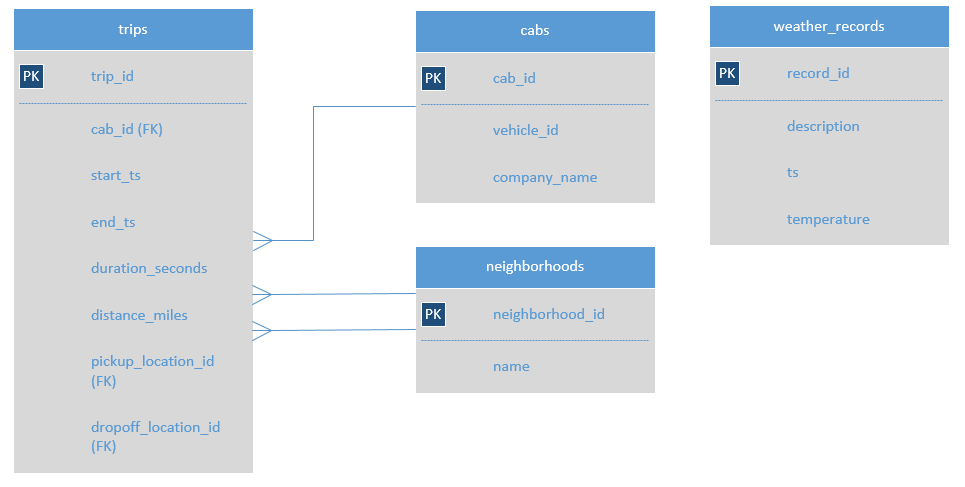

**Step 1:** <br>
Print the company names. Find the number of taxi rides for each taxi company for November 15-16, 2017 and print it, too. Sort the results by the number of taxi rides in descending order.

In [ ]:
SELECT
    cabs.company_name AS company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM
    trips
    INNER JOIN cabs ON trips.cab_id = cabs.cab_id
WHERE
    CAST(trips.start_ts AS date) = '2017-11-15'
    OR CAST(trips.start_ts AS date) = '2017-11-16'
GROUP BY
    company_name
ORDER BY
    trips_amount DESC;

**Step 2:** <br>
Find the number of rides for every taxi company whose name contains the words "Yellow" or "Blue" for November 1-7, 2017. Group the results by the company names.

In [ ]:
SELECT
    cabs.company_name AS company_name,
    COUNT(trips.trip_id) AS trips_amount
FROM
    trips
    INNER JOIN cabs ON trips.cab_id = cabs.cab_id
WHERE
    CAST(trips.start_ts AS date) >= '2017-11-01'
    AND CAST(trips.start_ts AS date) <= '2017-11-07'
    AND ( cabs.company_name LIKE '%Yellow%'
          OR cabs.company_name LIKE '%Blue%')
GROUP BY
    company_name;

**Step 3:** <br>
Find the number of rides for the two companies Flash Cab and Taxi Affiliation Services. Join the rides for all other companies in the group "Other". Group the data by taxi company names and sort the result in descending order by number of rides.

In [ ]:
SELECT
    CASE WHEN cabs.company_name NOT IN ('Flash Cab', 'Taxi Affiliation Services') THEN 'Other'
    ELSE cabs.company_name END AS company,
    COUNT(trips.trip_id) AS trips_amount
FROM
    trips
    INNER JOIN cabs ON trips.cab_id = cabs.cab_id
WHERE
    CAST(trips.start_ts AS date) >= '2017-11-01'
    AND CAST(trips.start_ts AS date) <= '2017-11-07'
GROUP BY
    company
ORDER BY
    trips_amount DESC;

**Step 4:** <br>
Retrieve the identifiers of the O'Hare and Loop neighborhoods from the neighborhoods table.

In [ ]:
SELECT
    neighborhood_id,
    name
FROM
    neighborhoods
WHERE
    name LIKE '%Hare' OR name LIKE 'Loop';

**Step 5:** <br>
For each hour, retrieve the weather condition records from the weather_records table. Break all hours into two groups: Bad if the description field contains the words rain or storm, and Good for others.

In [ ]:
SELECT
    ts,
    CASE WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
         WHEN description NOT LIKE '%rain%' AND description NOT LIKE '%storm%' THEN 'Good'
    ELSE description END AS weather_conditions
FROM
    weather_records;

**Step 6:** <br>
Retrieve from the trips table all the rides that started in the Loop (pickup_location_id: 50) on a Saturday and ended at O'Hare (dropoff_location_id: 63). Get the weather conditions for each ride. Also, retrieve the duration of each ride. Ignore rides for which data on weather conditions is not available. Sort by trip_id.

In [ ]:
SELECT
    trips.start_ts AS start_ts,
    subq.weather_conditions AS weather_conditions,
    trips.duration_seconds AS duration_seconds
FROM
    trips
    INNER JOIN (
        SELECT
            ts,
            CASE WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
                 WHEN description NOT LIKE '%rain%' AND description NOT LIKE '%storm%' THEN 'Good'
            ELSE description END AS weather_conditions
        FROM
            weather_records ) AS subq ON subq.ts = trips.start_ts
WHERE
    trips.pickup_location_id = 50 AND trips.dropoff_location_id = 63
    AND EXTRACT(ISODOW FROM trips.start_ts) = 6
ORDER BY
    trips.trip_id;

The resulting table is saved as 'df_weather'.

<a id="2"></a>

## 2) Open the data file and study the general information

<a id="2.1"></a>

### 2.1) Table 'df_comp'

In [1]:
# import libraries
import pandas as pd
from scipy import stats as st
from scipy.stats import levene
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

In [2]:
# read csv file
try:
    df_comp = pd.read_csv('C:/Users/Herbert/Documents/Practicum100/datasets/sql/project_sql_result_01.csv')
except:
    print("Couldn't read csv file.")

In [3]:
df_comp.sort_values('trips_amount', ascending = False).head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [4]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
company_name    64 non-null object
trips_amount    64 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


#### Conclusion

The table 'df_comp' has 64 rows and 2 columns which contain 64 company taxi names in object data type and 64 corresponding values for trip amounts in integer data type on November 15-16, 2017 in Chicago. As one can see in the table, the amounts vary from 2 to 19558. It stands out that the companies with very few companies have strange numbers in their names (e.g. '3556 - 36214 RC Andrews Cab'). In this table, we don't have missing values.

<a id="2.2"></a>

### 2.2) Table 'df_drop'

In [5]:
# read csv file
try:
    df_drop = pd.read_csv('C:/Users/Herbert/Documents/Practicum100/datasets/sql/project_sql_result_04.csv')
except:
    print("Couldn't read csv file.")

In [6]:
df_drop.sort_values('average_trips', ascending = False).head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [7]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
dropoff_location_name    94 non-null object
average_trips            94 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [8]:
# The time period over which the average has been calculated is not given.
# Let's compare the average trips summed up with the sum of the trips
# in the table 'df_comp' which shows the trips amount for 2 days (November 15-16, 2017)


# The sum of the trips for all companies in 2 days
sum_trips = df_comp['trips_amount'].sum()
# The sum of the average trips for all dropoff locations
sum_avg_trips = df_drop['average_trips'].sum()
# Relation of these 2 values
relation_trips = sum_trips / sum_avg_trips


print("The sum of the trips for all companies in 2 days:", sum_trips)
print()
print("The sum of the average trips for all dropoff locations:", '{:.1f}'.format(sum_avg_trips))
print()
print("Relation of these two values:")
print(sum_trips, '/', '{:.1f}'.format(sum_avg_trips))
print('= {:.1f}'.format(relation_trips))

The sum of the trips for all companies in 2 days: 137311

The sum of the average trips for all dropoff locations: 56395.7

Relation of these two values:
137311 / 56395.7
= 2.4


#### Conclusion

The table 'df_drop' has 94 rows and 2 columns. The column 'dropoff_location_name' shows neighborhoods where taxi rides ended in object data types and the column 'average_trips' gives the corresponding average number of trips for the dropoff locations in float data type. Here we can see again a great variation for the average number of trips taking values from 1.8 to 10727.46. There's no infomration given about the time period over which the average values have been calculated. Since the table 'df_comp' gives us trip amounts for 2 days and since the quote of the sum of the trips in the tables 'df_comp' and 'df_drop' is 2.4, we can assume that the average values in the table 'df_drop' are average values per day. In this table, we don't have missing values.

<a id="2.3"></a>

### 2.3) Table 'df_weather'

In [9]:
# read csv file
try:
    df_weather = pd.read_csv('C:/Users/Herbert/Documents/Practicum100/datasets/sql/project_sql_result_07.csv')
except:
    print("Couldn't read csv file.")

In [10]:
df_weather.sort_values('duration_seconds', ascending = False).head()

,start_ts,weather_conditions,duration_seconds
354,2017-11-25 11:00:00,Good,7440.0
619,2017-11-25 14:00:00,Good,6420.0
276,2017-11-18 12:00:00,Bad,4980.0
583,2017-11-11 16:00:00,Good,4980.0
79,2017-11-11 15:00:00,Good,4800.0


In [11]:
df_weather['weather_conditions'].value_counts()

Good    888
Bad     180
Name: weather_conditions, dtype: int64

In [12]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
start_ts              1068 non-null object
weather_conditions    1068 non-null object
duration_seconds      1068 non-null float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


#### Conclusion

The table 'df_weather' has 3 columns and 1068 rows and contains data on rides from the Loop to O'Hare International Airport. The column 'start_ts' shows the pickup date and time for a certain taxi ride in object data type. The column 'weather_conditions' shows the weather condition at the moment the ride started in object data type; Here, for the sake of simplicity, the conditions are only divided into 2 groups: 'Good' and 'Bad'. We have more values for 'Good' (888) than for 'Bad' (180). The column 'duration_seconds' shows the ride duration in units of seconds in float data type. In the table one can see that some durations are given with 0 seconds.
<br>
Overall, there is not a single missing value in all 3 tables.

<a id="3"></a>

## 3) Prepare the data

<a id="3.1"></a>

### 3.1) Replace the column names

Since some columns have long names I will shorten these names.

In [13]:
df_comp.columns = ['company', 'trips']

df_comp.head()

,company,trips
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [14]:
df_drop.columns = ['dropoff_loc', 'avg_trips']

df_drop.head()

,dropoff_loc,avg_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [15]:
df_weather.columns = ['start_ts', 'weather', 'duration_sec']

df_weather.head()

,start_ts,weather,duration_sec
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


<a id="3.2"></a>

### 3.2) Convert the data types

In [16]:
# Since we have big values for average trips in the table 'df_drop'
# I round the average number of trips
df_drop['avg_trips'] = df_drop['avg_trips'].round(0)


# I transform the numbers into integer data type
try:
    df_drop['avg_trips'] = df_drop['avg_trips'].astype('int64')
    print("Transformed 'avg_trips' into integer data type.")
except:
    print("Couldn't transform 'avg_trips' into integer data type.")

Transformed 'avg_trips' into integer data type.


In [17]:
# The distance between the Loop to O'Hare International Airport is at least 27 kilometers by car.
# That's the reason I delete all rows with ride durations under 10 minutes:

df_weather = df_weather[df_weather['duration_sec'] >= 600]

In [18]:
# Since we have big values for ride durations
# we can round the duration values
df_weather['duration_sec'] = df_weather['duration_sec'].round(0)


# I transform the numbers into integer data type
try:
    df_weather['duration_sec'] = df_weather['duration_sec'].astype('int64')
    print("Transformed 'duration_sec' into integer data type.")
except:
    print("Couldn't transform 'duration_sec' into integer data type.")

Transformed 'duration_sec' into integer data type.


In [19]:
# Tramsform the column 'start_ts' in the weather table into the datetime data type:

df_weather['start_ts'] = pd.to_datetime(df_weather['start_ts'], format = '%Y-%m-%d %H:%M:%S')

In [20]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058 entries, 0 to 1067
Data columns (total 3 columns):
start_ts        1058 non-null datetime64[ns]
weather         1058 non-null object
duration_sec    1058 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 33.1+ KB


In [21]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
dropoff_loc    94 non-null object
avg_trips      94 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [22]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
company    64 non-null object
trips      64 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


#### Conclusion

Since in our analysis we are interested in the top 10 locations in terms of dropoffs and since the values for average trips for these locations is in the range of thousands, rounding these values is not significant and we can transform these values into integer data type. We transform the row 'avg_trips' into integer data type. <br> <br> The timestamps in the column 'start_ts' of the table 'df_weather' have been transformed into the datetime data type applying the corresponding format. <br> <br> The table 'df_weather' gives us time durations for trips between the Loop and the O'Hare International Airport in Chicago. When searching for the distance between these two spots one has to cover by car - for example using Google Maps - the distance is at least 27 kilometers. Since we don't know exactly about the rides, we can at least delete all rides that are shorter than 10 minutes. The values in the column 'duration_sec' are rounded into whole seconds and they are transformed into integer data type.

<a id="3.3"></a>

### 3.3) Check for duplicates

###### Table 'df_comp'

In [23]:
# number of duplicated company names

print(df_comp['company'].duplicated().sum())

0


In [24]:
# We can see that some companies have strange numbers and hyphens in their names

df_comp.tail(5)

,company,trips
59,4053 - 40193 Adwar H. Nikola,7
60,2733 - 74600 Benny Jona,7
61,5874 - 73628 Sergey Cab Corp.,5
62,"2241 - 44667 - Felman Corp, Manuel Alonso",3
63,3556 - 36214 RC Andrews Cab,2


In [25]:
# I remove all numbers and hyphens in the company names in order to find 
# duplicated company names


# For every company name, I join all elements that are not digits
# to an empty string. After that I replace all hyphens with an empty string.
# I will create a second file since I don't want to change company names
# in case I don't find duplicated company names:

df_comp_2 = df_comp.copy()

for i in range(len(df_comp_2)):
    comp_name = df_comp_2.loc[i, 'company']
    comp_name = ''.join(j for j in comp_name if not j.isdigit())
    comp_name = comp_name.replace('-', '')
    df_comp_2.loc[i, 'company'] = comp_name

In [26]:
# Check if strange number combinations in company names are deleted

df_comp_2.tail(5)

,company,trips
59,Adwar H. Nikola,7
60,Benny Jona,7
61,Sergey Cab Corp.,5
62,"Felman Corp, Manuel Alonso",3
63,RC Andrews Cab,2


In [27]:
# number of duplicated company names with company names
# not containing strange number combinations

print(df_comp_2['company'].duplicated().sum())

0


Since I didn't find any duplicated company names after deleting all numbers and hyphens, we can use our table 'df_comp' with the original company names.

###### Table 'df_drop'

In [28]:
df_drop.sort_values('avg_trips', ascending = False).head(10)

,dropoff_loc,avg_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547
5,Lake View,2421
6,Grant Park,2069
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1260


In [29]:
# Check for duplicated dropoff location names

print(df_drop['dropoff_loc'].duplicated().sum())

0


###### Table 'df_weather'

In [30]:
df_weather.head()

,start_ts,weather,duration_sec
0,2017-11-25 16:00:00,Good,2410
1,2017-11-25 14:00:00,Good,1920
2,2017-11-25 12:00:00,Good,1543
3,2017-11-04 10:00:00,Good,2512
4,2017-11-11 07:00:00,Good,1440


In [31]:
# number of duplicated rows

print(df_weather.duplicated().sum())

197


In [32]:
print("Length of table 'df_weather' before deleting duplicates:")
print(len(df_weather))
print()
print("Value counts of weather conditions before deleting duplicates:")
print(df_weather['weather'].value_counts())

Length of table 'df_weather' before deleting duplicates:
1058

Value counts of weather conditions before deleting duplicates:
Good    880
Bad     178
Name: weather, dtype: int64


In [33]:
print("Length of table 'df_weather' after deleting duplicates:")
print(len(df_weather.drop_duplicates()))
print()
print("Value counts of weather conditions after deleting duplicates:")
print(df_weather.drop_duplicates().loc[:, 'weather'].value_counts())

Length of table 'df_weather' after deleting duplicates:
861

Value counts of weather conditions after deleting duplicates:
Good    715
Bad     146
Name: weather, dtype: int64


Since the timestamps are rounded into whole hours,
there are listed multiple rides for every hour.
It's unlikely to be accurate to the second twice
in the same hour.

In [34]:
# After deleting the duplicates, there are still enough rows
# with 'good' and 'bad' weather conditions,
# so I decide to delete these duplicates:

df_weather = df_weather.drop_duplicates()

In [35]:
# Let's check if all timestamps are rounded to full hours

# Add helping columns: 'second' and 'minute'; they show
# the minute and second values from the timestamp 'start_ts'.
# They should all have the value 0 as the only value

df_weather['second'] = df_weather['start_ts'].dt.second
df_weather['minute'] = df_weather['start_ts'].dt.minute

print(df_weather['second'].value_counts())
print(df_weather['minute'].value_counts())

0    861
Name: second, dtype: int64
0    861
Name: minute, dtype: int64


In [36]:
# All timestamps are rounded to full hours

# We can remove the helping columns
df_weather = df_weather.drop(columns = ['second', 'minute'])

#### Conclusion

In the table 'df_comp' we didn't find any duplicated companies. We have seen that some companies have strange number combinations in their names (like '5874 - 73628 Sergey Cab Corp.'). I wanted to see if there are duplicated company names when deleting these numbers. Since I still didn't find any duplicates, I left the original company names including the number combinations. <br> <br> Also the table 'df_drop' doesn't have any duplicated locations in the column 'dropoff_loc'. <br> <br> The only table containing duplicates is 'df_weather'. Here, all timestamps in the column 'start_ts' are rounded to full hours. The duplicates could be explained by the timestamps which are rounded to full hours and by the thousands of taxi rides every day. On the other hand, we have only a slice of all rides in the table: Only 1058. It's unlikely that two rides being accurate to the second are in one table. Since, after deleting the duplicates, we still have enough rows with the weather condition 'bad', we can delete the duplicates and use the data for the test of the hypothesis.

<a id="4"></a>

## 4) Analysis

<a id="4.1"></a>

### 4.1) Top 10 neighborhoods by number of dropoffs

In [37]:
# Let's show the top 10 most visited neighbourhoods in Chicago reached by taxi

df_drop = df_drop.sort_values(by='avg_trips', ascending = False)

In [38]:
df_drop.head(10)

,dropoff_loc,avg_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547
5,Lake View,2421
6,Grant Park,2069
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1260


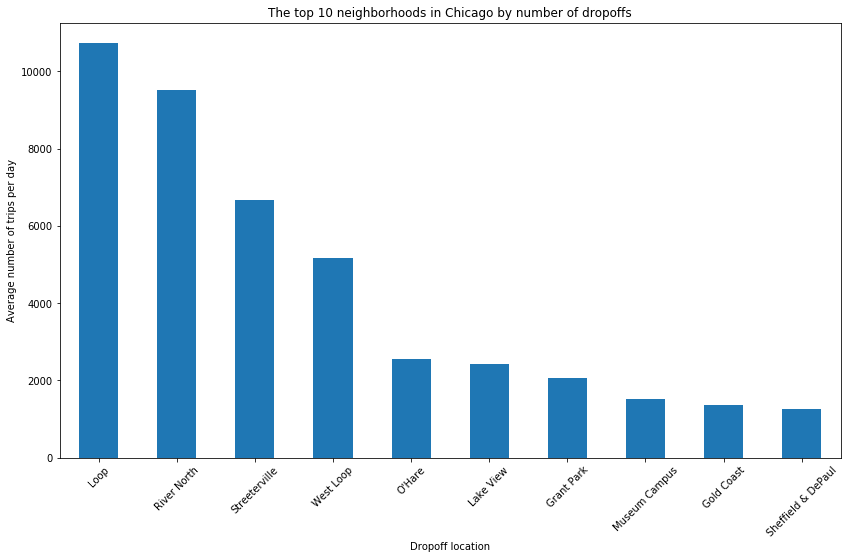

In [39]:
# From the table, one sees the condition for having the top ten locations
df_top_10 = df_drop[df_drop['avg_trips'] >= 1260].set_index('dropoff_loc')
df_top_10.columns = ['Average number of trips per day']

# Let's create a bar chart

# set figure size
rcParams['figure.figsize'] = 14,8
df_top_10.plot(kind='bar', legend = None)
plt.ylabel('Average number of trips per day')
plt.xlabel('Dropoff location')
plt.title('The top 10 neighborhoods in Chicago by number of dropoffs')
plt.xticks(rotation=45)
plt.show()

#### Conclusion

The 4 neighbourhoods with the greatest average trips have over 5000 trips per day. These 4 neighbourhoods are all located very central in Chicago. With a bigger distance, the 5th and 6th top dropoff loations are the O'Hare Airport and Lake View, both having less than 3000 trips per day in average. In exception to these 2 locations, the dropoff locations being ranked 7 to 10 are central located in Chicago. That means, in exception of Lake View and O'Hare Airport, 8 of the top 10 dropoff locations are located in the vicinity of the Loop. This can be explained by the internationality of the Airport and the big area of Lake View.

<a id="4.2"></a>

### 4.2) Taxi companies and number of rides

In [40]:
# sort values in table 'df_comp' by trip amounts
df_comp = df_comp.sort_values('trips', ascending = False)

In [41]:
# Number of companies in our table
len(df_comp)

64

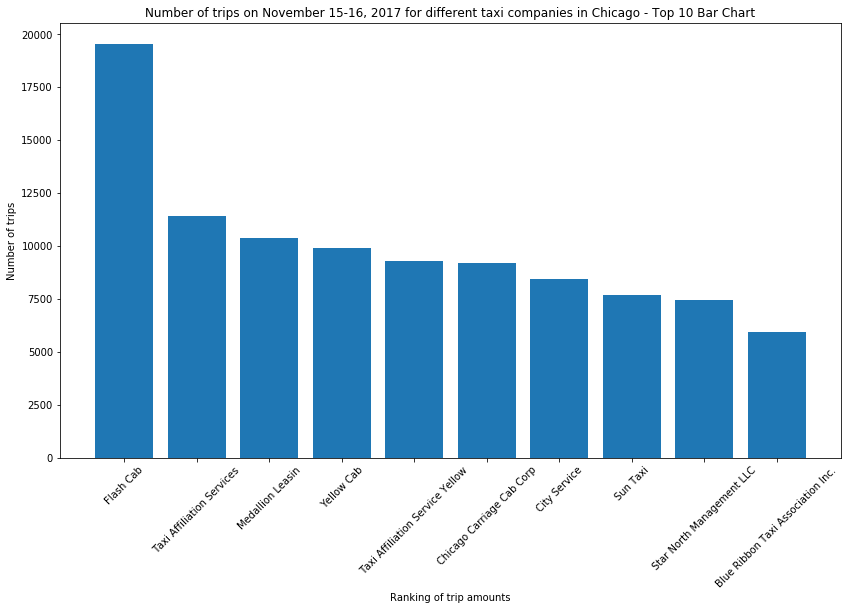

In [42]:
# Bar chart of the top 10

plt.bar(np.arange(10), df_comp.loc[0:9]['trips'])
plt.xticks(np.arange(10), df_comp.loc[0:9]['company'], rotation = 45)
plt.title('Number of trips on November 15-16, 2017 for different taxi companies in Chicago - Top 10 Bar Chart')
plt.xlabel("Ranking of trip amounts")
plt.ylabel('Number of trips')
plt.show()

The bar chart above shows the top 10 taxi companies with the most rides counted on these two days. One can clearly see a leading company named "Flash Cab".

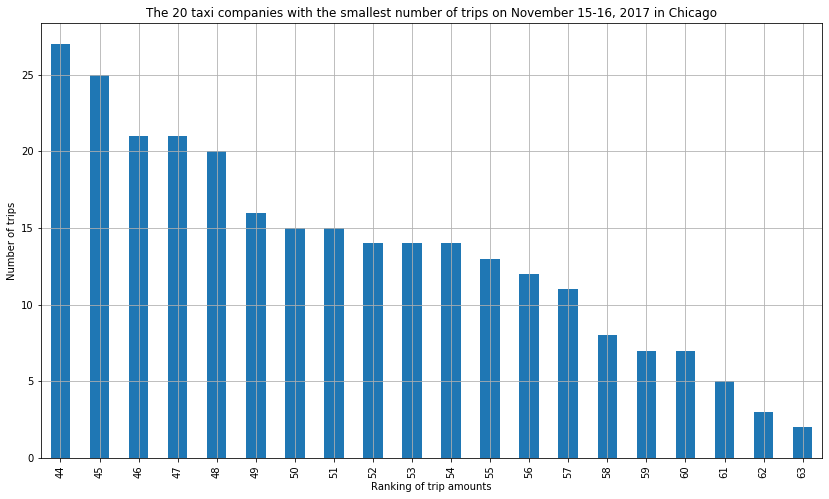

In [43]:
# Bar chart for the 20 smallest companies

df_comp.loc[44:63]['trips'].plot(kind='bar', grid = True, legend = None)
plt.title('The 20 taxi companies with the smallest number of trips on November 15-16, 2017 in Chicago')
plt.xlabel("Ranking of trip amounts")
plt.ylabel('Number of trips')
plt.show()

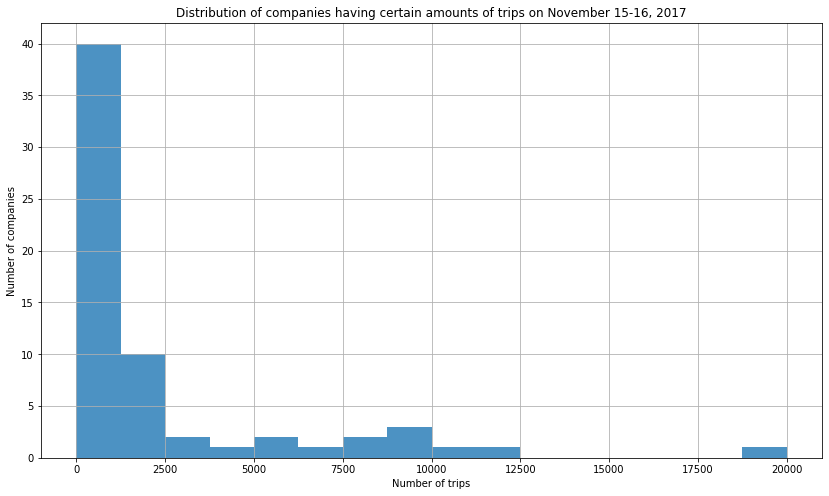

In [44]:
# Histogram

df_comp['trips'].hist(bins = [0, 1250, 2500, 3750, 5000, 6250, 7500, 8750, 10000, 11250, 12500, 13750, 15000, \
                             16250, 17500, 18750, 20000], alpha = 0.8)
plt.title('Distribution of companies having certain amounts of trips on November 15-16, 2017')
plt.xlabel('Number of trips')
plt.ylabel('Number of companies')
plt.show()

#### Conclusion

In the bar chart showing the top 10 taxi companies in terms of trip amounts we can see that the market leader taxi company in Chicago (Flash Cab, 19558 trips) has a significant distance to the second biggest taxi company in Chicago (Taxi Affiliation Services, 11422). That means that 'Flash Cab' has counted around 71% more taxi trips than 'Taxi Affiliation Services'. One can observe that the top 10 taxi companies have more than 5000 trips. <br> <br> The bar chart including the smallest 20 companies shows that in total, 19 of 64 companies have counted not more than 25 trips in these two days. That means that there are multiple taxi companies having a very small market share in Chicago. It's likely that some of these small companies are private citizens offering taxi services for earning more money, for example: <br>
60, 4053 - 40193 Adwar H. Nikola, 7 trips; <br>
61, 2733 - 74600 Benny Jona, 7 trips.
<br> <br>
The Histogram showing the number of companies having certain amounts of trips reveals that 40 of 64 companies have less than 1250 trips on November 15-16, 2017; and 50 of 64 companies have less than 2500 trips on these two days. These observations lead to the assumption that the demand of taxis is very high in Chicago, so that even small companies and private citizens have many customers every day. That also means that there's existing a big competition between taxi companies for gaining a big market share in Chicago.

<a id="5"></a>

## 5) Test of the hypothesis

Hypothesis: "The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."

<a id="5.1"></a>

### 5.1) Prepare the data

In [45]:
# For the test, we need to add a column showing the day of the week of the ride:

df_weather['day_of_week'] = df_weather['start_ts'].dt.weekday

print(df_weather['day_of_week'].value_counts())

5    861
Name: day_of_week, dtype: int64


In [46]:
# All dates in the weather table are on Saturdays,
# so we can remove that column

df_weather = df_weather.drop(columns = 'day_of_week')

In [47]:
# divide the data frame into two data frames for each weather condition

df_good = df_weather.query('weather == "Good"')
df_bad = df_weather.query('weather == "Bad"')

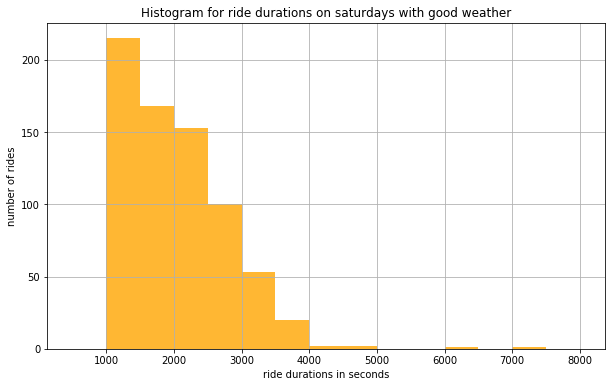

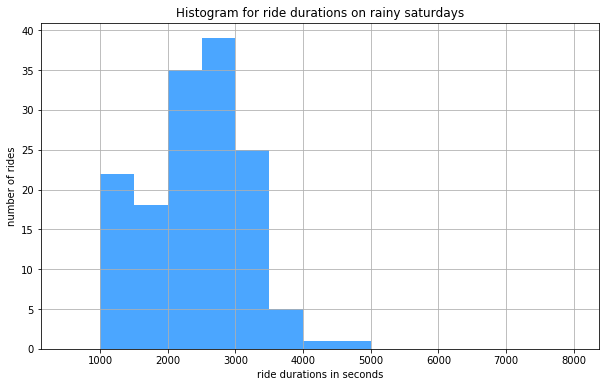

In [48]:
# Histogram for good weather

# set figure size
rcParams['figure.figsize'] = 10,6

df_good['duration_sec'].hist(bins = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500,  \
                                     8000], alpha = 0.8,  color = 'orange')
plt.title('Histogram for ride durations on saturdays with good weather')
plt.xlabel('ride durations in seconds')
plt.ylabel('number of rides')
plt.show()

# Histogram for bad weather

df_bad['duration_sec'].hist(bins = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, \
                                    8000],alpha = 0.8, color = 'dodgerblue')
plt.title('Histogram for ride durations on rainy saturdays')
plt.xlabel('ride durations in seconds')
plt.ylabel('number of rides')
plt.show()

<a id="5.2"></a>

### 5.2) Test of the hypothesis

###### Check the equality of samples

In [49]:
print("#### Infos about samples")
print()
print("Size of 'good weather' sample:", len(df_good))
print("Size of 'rainy weather' sample:", len(df_bad))
print()
print("Ride duration mean value for good weather: {:.0f} seconds".format(df_good['duration_sec'].mean()))
print("Ride duration mean value for rainy weather: {:.0f} seconds".format(df_bad['duration_sec'].mean()))
print()
print("Ride duration variance for good weather: {:.0f} seconds^2".format(df_good['duration_sec'].std()**2))
print("Ride duration variance for rainy weather: {:.0f} seconds^2".format(df_bad['duration_sec'].std()**2))
print()
print()
print("#### Check equality of variances")
print()
print("As one can see in the histograms above, we have significant deviations from normal distributions for ride durations.")
print("The distribution for good weather is exponentially and the distribution for rainy weather is right skewed.")
print("So, we use the Levene's test for checking equality of variances.")
print()
print("Null hypothesis: Both samples are from populations with equal variances.")
print("Alternative hypothesis: Both samples are from populations with unequal variances.")
print()
print("Critical statistical significance level: alpha = 5%; if the p-value is less than alpha, we reject the null hypothesis.")
print()

alpha = 0.05
stat, p_value_levene = levene(df_good['duration_sec'], df_bad['duration_sec'], center = 'median')

print('p-value from levene test: ', p_value_levene)
print()

if (p_value_levene < alpha):
        print("We reject the null hypothesis.")
else:
        print("We can't reject the null hypothesis.")
print()
print("So for the statistical test we can assume equal variances.")

#### Infos about samples

Size of 'good weather' sample: 715
Size of 'rainy weather' sample: 146

Ride duration mean value for good weather: 2054 seconds
Ride duration mean value for rainy weather: 2436 seconds

Ride duration variance for good weather: 560637 seconds^2
Ride duration variance for rainy weather: 520570 seconds^2


#### Check equality of variances

As one can see in the histograms above, we have significant deviations from normal distributions for ride durations.
The distribution for good weather is exponentially and the distribution for rainy weather is right skewed.
So, we use the Levene's test for checking equality of variances.

Null hypothesis: Both samples are from populations with equal variances.
Alternative hypothesis: Both samples are from populations with unequal variances.

Critical statistical significance level: alpha = 5%; if the p-value is less than alpha, we reject the null hypothesis.

p-value from levene test:  0.8862949928013623

We can't reject the nu

###### Test of hypothesis

In [50]:
print("We can assume equal variances. If we use the student-t-test, we would use a parametric")
print("test. For not-normal distributions we should change to a non-parametric test. We have a two-sided test for two")
print("independent samples which have significantly different sizes.")
print("That's why we use the Mann-Whitney-U-Test.")

print()
print("We bring the samples in the same size.")
print()

df_good_sample = df_good.sample(n = len(df_bad))

print("Null hypothesis:")
print("The average ride duration from the Loop to O'Hare International Airport doesn't change significantly on rainy saturdays.")
print()
print("Alternative hypothesis:")
print("The average ride duration from the Loop to O'Hare International Airport changes significantly on rainy saturdays.")
print()
print("Critical statistical significance level: alpha = 1%; if the p-value is less than alpha, we reject the null hypothesis.")
print()

alpha = 0.01
u_statistic, p_value = st.mannwhitneyu(df_good_sample['duration_sec'],df_bad['duration_sec'])
    
print('p-value from Mann-Whitney-U-Test: ', p_value)
print()

if (p_value < alpha):
        print("We reject the null hypothesis.")
else:
        print("We can't reject the null hypothesis.")

We can assume equal variances. If we use the student-t-test, we would use a parametric
test. For not-normal distributions we should change to a non-parametric test. We have a two-sided test for two
independent samples which have significantly different sizes.
That's why we use the Mann-Whitney-U-Test.

We bring the samples in the same size.

Null hypothesis:
The average ride duration from the Loop to O'Hare International Airport doesn't change significantly on rainy saturdays.

Alternative hypothesis:
The average ride duration from the Loop to O'Hare International Airport changes significantly on rainy saturdays.

Critical statistical significance level: alpha = 1%; if the p-value is less than alpha, we reject the null hypothesis.

p-value from Mann-Whitney-U-Test:  8.513472364615353e-06

We reject the null hypothesis.


<a id="5.3"></a>

### 5.3) Conclusion

The Histogram for saturdays with good weather resembled an exponentially distribution whereas the histogram for saturdays with rainy weather resembled a right skewed distribution. For checking out the equality of the variances for the good-weather-sample and the rainy-weather-sample, I therefore used the Levene Test. This test results in not rejecting the hypothesis of equal variances. The important values for these 2 samples are calculated:
<br> <br>
Ride duration mean value for good weather: 2,054 seconds <br>
Ride duration mean value for rainy weather: 2,436 seconds
<br> <br>
Ride duration variance for good weather: 560,637 seconds^2 <br>
Ride duration variance for rainy weather: 520,570 seconds^2
<br> <br>
One can observe that the mean values are much smaller than the variance values. The mean value for rainy weather is around 20% higher than the one for good weather, the variance for good weather is around 7% higher than the one for rainy weather. This is the reason why the hypothesis test has a significance level of 1%. <br> <br>
Since we have big variations from normality in our samples and since we have a two-sided test of independent samples of significantly different sizes, I used the Mann-Whitney-U-Test. Even though the significance level is set on 1%, we can reject the null hypothesis, that the average ride duration from the Loop to O'Hare International Airport doesn't change significantly on rainy saturdays. That means we can assume that the change in duration of rides on rainy saturdays is statistically significant.

<a id="6"></a>

## 6) General conclusion

In the Analysis, we started with the top 10 neighborhoods of Chicago in terms of dropoffs. We observed that - besides the O'Hare International Airport - all locations are in the vicinity of the Loop. That means that the most demanded dropoff locations are located very central in Chicago. <br> <br>
When looking at the trip amounts of 64 taxi companies in Chicago in November 15-16, 2017, we determined the market leader in Chicago: 'Flash Cab' with over 19,000 trips in these two days. We also found that 23 of the 64 companies have counted less than 30 trips - likely including private citizens offering taxi services. That means on the one hand a big demand of taxi services in Chicago and on the other hand a big competition in that business. <br> <br>
Using the Mann-Whitney-U-Test with a significance level of 1%, we rejected the hypothesis 'The average ride duration from the Loop to O'Hare International Airport doesn't change significantly on rainy saturdays'. From a statistical point of view its alternative hypothesis - that the ride durations change on rainy saturdays - can be assumed. We take a look again at the mean values: <br> <br>
Ride duration mean value for good weather: 2,054 seconds <br>
Ride duration mean value for rainy weather: 2,436 seconds
<br> <br>
The result of the hypothesis test implies that the difference between these two mean values is statistically significant. It becomes more obvious when calculating their standard deviations; for example the one for good weather which results from the square root of 560,637 and is given by 749 seconds.
<br> <br>
We can see hints for improving taxi companies in Chicago: <br>
- The company may focus on the most demanded dropoff locations and can make special offers regarding these locations
- A look at the website of the market leader 'Flash Cab' points out a special offer: 'Preferred Airport Service': <br>
"Flash Cab affiliates serve both O’Hare and Midway airport by offering a comfortable and economical ride from your front door right to your terminal gate with plenty of trunk space." <br>
Since the O'Hare Airport is many miles away from the center of Chicago, a good offer in that area may increase the number of trips.